In [46]:
library(tidyverse)

library(rsample)
library(caret)
library(vip)

In [47]:
attrition <- read.csv("C:/Users/apf_temp_admin/Documents/Hands on Machine Learning/WA_Fn-UseC_-HR-Employee-Attrition.csv",
                     stringsAsFactors = T)

In [48]:
colnames(attrition)[1] <- "Age"

In [49]:
head(attrition)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6


In [50]:
table(attrition$Attrition) %>% prop.table()


       No       Yes 
0.8387755 0.1612245 

#### attrition 변수의 비율이 불균형 하기에 층화추출

In [51]:
set.seed(123)
churn_split <- rsample::initial_split(attrition, prop = 0.7, strata = "Attrition")
churn_train <- training(churn_split)
churn_test <- testing(churn_split)
dim(churn_train) ; dim(churn_test)

[1] 1028   35

[1] 442  35

### 단순 로지스틱 회귀

In [52]:
model1 <- glm(Attrition ~ MonthlyIncome, family = "binomial", data = churn_train)
model2 <- glm(Attrition ~ OverTime, family = "binomial", data = churn_train)

In [53]:
tidy(model1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.8860896268,1.572318e-01,-5.635561,1.74489e-08
MonthlyIncome,-0.0001386248,2.719376e-05,-5.097669,3.43861e-07


In [54]:
tidy(model2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.128834,0.1190087,-17.888057,1.461161e-71
OverTimeYes,1.289877,0.1755451,7.347836,2.014409e-13


In [55]:
exp(coef(model1)) 
exp(coef(model2))

(Intercept) MonthlyIncome 
    0.4122647     0.9998614

(Intercept) OverTimeYes 
  0.1189759   3.6323389

- 감원하는 직원의 오즈는 1달러 증가할 때마다 0.999씩 증가하는 반면, 일 하지 않는 직원과 비교하여 일하는 직원 MonthlyIncome의 감원의 오즈는 3.6323배 증가

#### 계수의 신뢰구간

In [56]:
confint(model1)
confint(model2)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-1.1932606571,-5.761048e-01
MonthlyIncome,-0.0001948723,-8.803311e-05


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-2.3695727,-1.902409
OverTimeYes,0.9463761,1.635373


### 다중 로지스틱 회귀

In [57]:
model3 <- glm(
  Attrition ~ MonthlyIncome + OverTime,
  family = "binomial", 
  data = churn_train
)

In [58]:
tidy(model3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.3332716951,1.768545e-01,-7.538806,4.742933e-14
MonthlyIncome,-0.0001474254,2.798602e-05,-5.267825,1.380495e-07
OverTimeYes,1.3492849314,1.800073e-01,7.495722,6.593417e-14


### 모델 정확도 평가

### ```method = "glm"```
### ```family - "binomial```

#### 범주가 1개인 범주형 변수 제거

In [79]:
cats = vector()
for (i in 1:length(attrition)) {
    cats[i] = n_distinct(attrition[i])
}

In [80]:
which(cats == 1)

[1]  9 22 27

In [89]:
set.seed(123)
cv_model1 <- train(
  Attrition ~ MonthlyIncome, 
  data = churn_train[, -c(9, 22, 27)], 
  method = "glm",
  family = "binomial",
  trControl = trainControl(method = "cv", number = 10)
)

In [90]:
set.seed(123)
cv_model2 <- train(
  Attrition ~ MonthlyIncome + OverTime, 
  data = churn_train[, -c(9, 22, 27)], 
  method = "glm",
  family = "binomial",
  trControl = trainControl(method = "cv", number = 10)
)

In [91]:
set.seed(123)
cv_model3 <- train(
    Attrition ~ .,
    data = churn_train[, -c(9, 22, 27)],
    method = "glm",
    family = "binomial",
    trControl = trainControl(method = "cv", number = 10)
)

In [97]:
summary(
  resamples(
    list(
      model1 = cv_model1, 
      model2 = cv_model2, 
      model3 = cv_model3
    )
  )
)


Call:
summary.resamples(object = resamples(list(model1 = cv_model1, model2
 = cv_model2, model3 = cv_model3)))

Models: model1, model2, model3 
Number of resamples: 10 

Accuracy 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
model1 0.8349515 0.8349515 0.8398379 0.8395076 0.8431373 0.8446602    0
model2 0.8349515 0.8349515 0.8398379 0.8395076 0.8431373 0.8446602    0
model3 0.8349515 0.8564630 0.8743932 0.8735175 0.8832096 0.9126214    0

Kappa 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
model1 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000    0
model2 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000    0
model3 0.2791272 0.4074426 0.4441872 0.4574284 0.5008789 0.6183615    0


### 혼동행렬

In [116]:
pred_class <- predict(cv_model3, data = churn_train[, -c(9, 22, 27)])

In [117]:
pred_class <- as.factor(ifelse(pred_class == "No", 0, 1))
actual_class <- as.factor(ifelse(churn_train$Attrition == "No", 0, 1))

In [118]:
confusionMatrix(data = pred_class, reference = actual_class)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 842  89
         1  21  76
                                          
               Accuracy : 0.893           
                 95% CI : (0.8725, 0.9112)
    No Information Rate : 0.8395          
    P-Value [Acc > NIR] : 5.738e-07       
                                          
                  Kappa : 0.5235          
                                          
 Mcnemar's Test P-Value : 1.679e-10       
                                          
            Sensitivity : 0.9757          
            Specificity : 0.4606          
         Pos Pred Value : 0.9044          
         Neg Pred Value : 0.7835          
             Prevalence : 0.8395          
         Detection Rate : 0.8191          
   Detection Prevalence : 0.9056          
      Balanced Accuracy : 0.7181          
                                          
       'Positive' Class : 0               
                              

### ROC-Curve

In [120]:
library(ROCR)

In [129]:
m1_prob <- predict(cv_model1, churn_train, type = "prob")[2]
m3_prob <- predict(cv_model3, churn_train, type = "prob")[2]

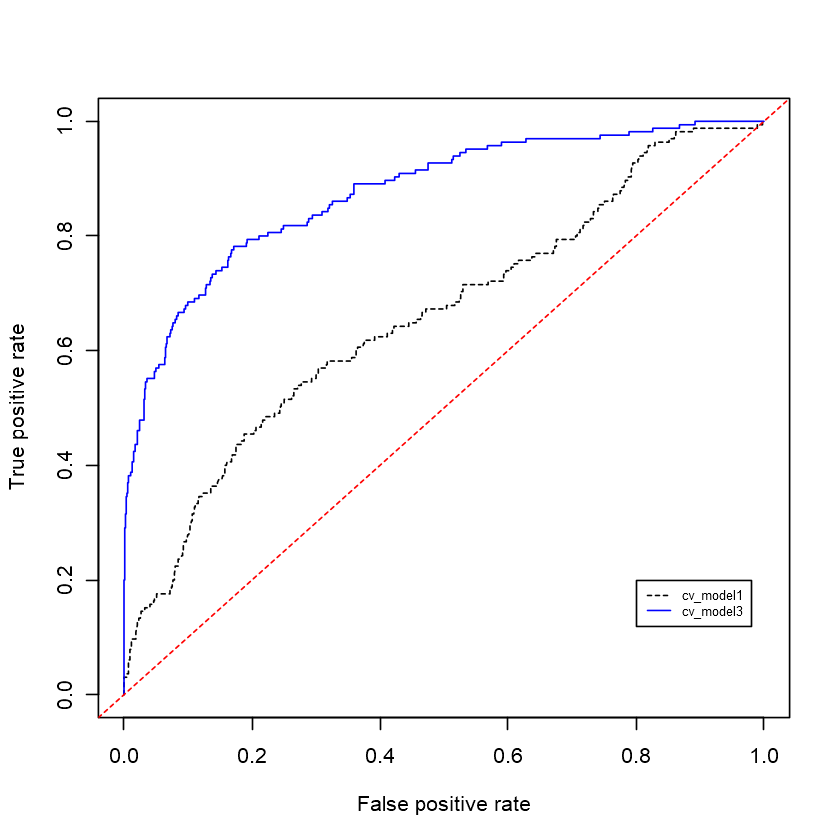

In [141]:
roc1 <- prediction(m1_prob, churn_train$Attrition)
perf1 <- performance(roc1, "tpr", "fpr")

roc2 <- prediction(m3_prob, churn_train$Attrition)
perf2 <- performance(roc2, "tpr", "fpr")

plot(perf1, col = "black", lty = 2)
plot(perf2, add = TRUE, col = "blue")
legend(0.8, 0.2, legend = c("cv_model1", "cv_model3"),
       col = c("black", "blue"), lty = 2:1, cex = 0.6)
abline(a = 0, b = 1, lty = 2, col = "red")

### AUC

In [144]:
auc1 <- performance(roc1, "auc")
auc2 <- performance(roc2, "auc")

### PLS 로지스틱 회귀

In [146]:
set.seed(123)
cv_model_pls <- train(
  Attrition ~ ., 
  data = churn_train[, -c(9, 22, 27)], 
  method = "pls",
  family = "binomial",
  trControl = trainControl(method = "cv", number = 10),
  preProcess = c("zv", "center", "scale"),
  tuneLength = 16
)

In [147]:
cv_model_pls$bestTune

,ncomp
,<dbl>
11,11


In [148]:
cv_model_pls$results %>% filter(ncomp == unlist(cv_model_pls$bestTune)[1])

ncomp,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,0.8725655,0.3315591,0.01856731,0.1243606


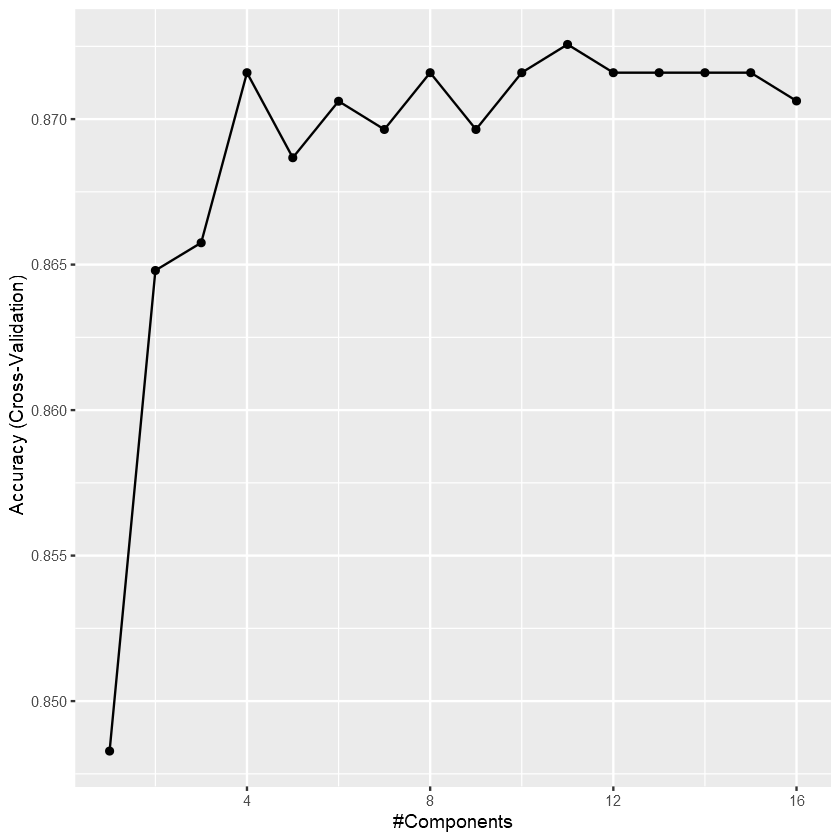

In [149]:
ggplot(cv_model_pls)

### 변수 중요도

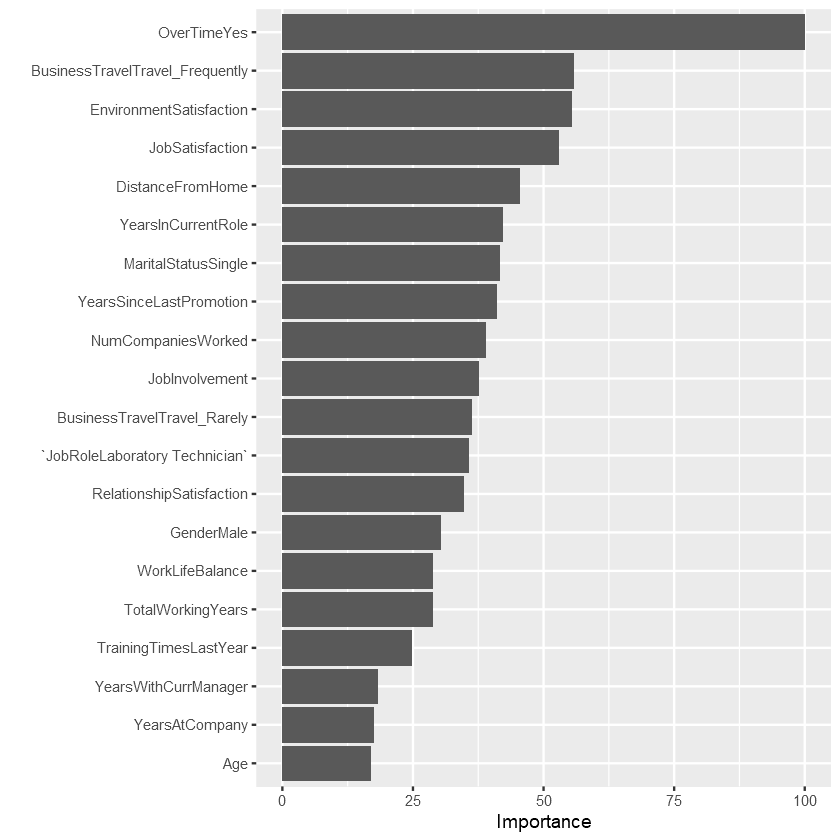

In [150]:
vip::vip(cv_model3, num_features = 20)

### PDP

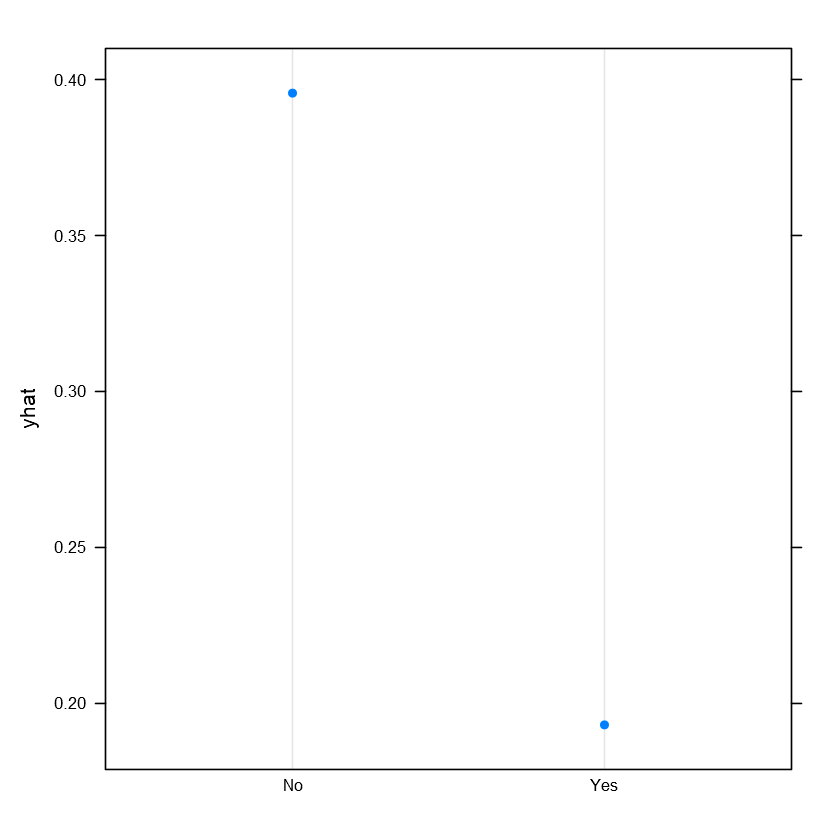

In [156]:
pdp::partial(cv_model_pls, "OverTime", plot = TRUE)